In [105]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
from sklearn.model_selection import train_test_split
iris = load_iris()

In [106]:
X = iris['data']
y = iris['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [107]:
import numpy as np
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [108]:
left_nodes = clf.tree_.children_left[clf.tree_.children_left>0]
right_nodes = clf.tree_.children_right[clf.tree_.children_right>0]

In [109]:
left_nodes

array([ 1,  3,  4,  5,  8, 10, 13, 14])

In [110]:
right_nodes

array([ 2, 12,  7,  6,  9, 11, 16, 15])

In [111]:
clf.tree_.node_count

17

In [112]:
## Extract path
node_indicator = clf.decision_path(X)

In [113]:
path_list = []
for i, j in enumerate(X):
    path_list.append(node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]])

In [114]:
path_list[0]

array([0, 1], dtype=int32)

In [115]:
## Convert path to strings
path_column = np.array([])
for i, j in enumerate(X):
    path_as_string = []
    for node in path_list[i]:
        if node == 0:
            path_as_string.append('START')
        elif node in left_nodes:
            path_as_string.append('LEFT')
        elif node in right_nodes:
            path_as_string.append('RIGHT')
            
    path_as_string.append('END')
    path_as_string = ' '.join(path_as_string)
    path_column = np.append(path_column, path_as_string)

# X[:,:-1] = path_column.reshape(-1,1)
            

In [116]:
X = np.hstack((X, path_column.reshape(-1,1)))

In [120]:
path_sequence = X[:,4]

In [15]:
import pandas as pd
data = pd.DataFrame(X)

In [34]:
data

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,START LEFT END
1,4.9,3.0,1.4,0.2,START LEFT END
2,4.7,3.2,1.3,0.2,START LEFT END
3,4.6,3.1,1.5,0.2,START LEFT END
4,5.0,3.6,1.4,0.2,START LEFT END
5,5.4,3.9,1.7,0.4,START LEFT END
6,4.6,3.4,1.4,0.3,START LEFT END
7,5.0,3.4,1.5,0.2,START LEFT END
8,4.4,2.9,1.4,0.2,START LEFT END
9,4.9,3.1,1.5,0.1,START LEFT END


In [16]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer()

tok.fit_on_texts(data[4])

## Fixed input variable output.
## Search for the right arch. Not the cells/states

In [19]:
word_idx = tok.word_index
idx_word = tok.index_word
num_words = len(word_idx) + 1
word_counts = tok.word_counts

# Convert text to sequences of integers
sequences = tok.texts_to_sequences(data[4])

In [172]:
sequences

[[3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 [3, 2, 1, 1, 1, 4],
 

In [60]:
from keras.utils import to_categorical

np.asarray(sequences)

s_array = np.array(np.array(x) for x in sequences)

In [65]:
s_df = pd.DataFrame(sequences)

In [173]:
s_df

,0,1,2,3,4,5,6
0,3,1,4,NaN,NaN,NaN,NaN
1,3,1,4,NaN,NaN,NaN,NaN
2,3,1,4,NaN,NaN,NaN,NaN
3,3,1,4,NaN,NaN,NaN,NaN
4,3,1,4,NaN,NaN,NaN,NaN
5,3,1,4,NaN,NaN,NaN,NaN
6,3,1,4,NaN,NaN,NaN,NaN
7,3,1,4,NaN,NaN,NaN,NaN
8,3,1,4,NaN,NaN,NaN,NaN
9,3,1,4,NaN,NaN,NaN,NaN


In [70]:
## Trial 1
## Add first 2 steps as feature and predict third step
## Merge X and first 2 columns from steps
## Extract 3rd step as target
## OHE this target
## Train on SimpleRNN and predict

feature = data.iloc[:,:4]

feature[5] = s_df.iloc[:,0]
feature[6] = s_df.iloc[:,1]

target = s_df.iloc[:, 2]

0      4
1      4
2      4
3      4
4      4
5      4
6      4
7      4
8      4
9      4
10     4
11     4
12     4
13     4
14     4
15     4
16     4
17     4
18     4
19     4
20     4
21     4
22     4
23     4
24     4
25     4
26     4
27     4
28     4
29     4
      ..
120    2
121    2
122    2
123    2
124    2
125    2
126    2
127    2
128    2
129    1
130    2
131    2
132    2
133    1
134    1
135    2
136    2
137    2
138    2
139    2
140    2
141    2
142    2
143    2
144    2
145    2
146    2
147    2
148    2
149    2
Name: 2, Length: 150, dtype: int64

In [174]:
feature

,0,1,2,3,5,6
0,5.1,3.5,1.4,0.2,3,1
1,4.9,3.0,1.4,0.2,3,1
2,4.7,3.2,1.3,0.2,3,1
3,4.6,3.1,1.5,0.2,3,1
4,5.0,3.6,1.4,0.2,3,1
5,5.4,3.9,1.7,0.4,3,1
6,4.6,3.4,1.4,0.3,3,1
7,5.0,3.4,1.5,0.2,3,1
8,4.4,2.9,1.4,0.2,3,1
9,4.9,3.1,1.5,0.1,3,1


In [71]:
# target = to_categorical(target)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0.

In [175]:
target

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0.

In [81]:
x_train = feature[:100]
y_train = target[:100]
x_test = feature[100:150]
y_test = target[100:150]

In [103]:
type(x_train)

pandas.core.frame.DataFrame

### RNN implementation

Notes

1) Split into 2 models
2) First model - basic feed forward. Second model - LSTM sequence to seq model
3) Concat 2 models
4) Merge at Dense to Dense(Hidden layers of both models)
5) Fix the seq generation part first. Then move on to attaching the prior model.


#### Preprocessing dataset

In [87]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, SimpleRNN
from keras.optimizers import Adam

from keras.utils import plot_model

#### Model using SimpleRNN - Phase I

In [168]:
model = Sequential()

model.add(Dense_1)
model.add(SimpleRNN(units=32, input_shape=(1,6), activation="sigmoid"))
model.add(Dense_2(8, activation="sigmoid"))
# model.add(Dropout(0.5))
model.add(Dense(5))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 32)                1248      
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 45        
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.fit(np.reshape(x_train.values,(100,1,6)), y_train, epochs=10)

Epoch 1/10
100/100 [==============================] - 1s 6ms/step - loss: 2.4749 - acc: 0.0100
Epoch 2/10
100/100 [==============================] - 0s 63us/step - loss: 2.0716 - acc: 0.0100
Epoch 3/10
100/100 [==============================] - 0s 115us/step - loss: 1.8402 - acc: 0.0100
Epoch 4/10
100/100 [==============================] - 0s 83us/step - loss: 1.6888 - acc: 0.0100
Epoch 5/10
100/100 [==============================] - 0s 75us/step - loss: 1.5753 - acc: 0.0100
Epoch 6/10
100/100 [==============================] - 0s 98us/step - loss: 1.4861 - acc: 0.0100
Epoch 7/10
100/100 [==============================] - 0s 70us/step - loss: 1.4127 - acc: 0.0100
Epoch 8/10
100/100 [==============================] - 0s 106us/step - loss: 1.3496 - acc: 0.0100
Epoch 9/10
100/100 [==============================] - 0s 84us/step - loss: 1.2927 - acc: 0.0100
Epoch 10/10
100/100 [==============================] - 0s 61us/step - loss: 1.2407 - acc: 0.0100


In [166]:
model.evaluate(np.reshape(x_test.values,(50,1,6)), y_test)

50/50 [==============================] - 0s 8ms/step


[1.4500318574905395, 0.0]

In [167]:
model.predict_classes(np.reshape(x_test.values,(50,1,6)))

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [128]:
model.metrics_names

['loss', 'acc']

In [171]:
model.predict(4)

AttributeError: 'int' object has no attribute 'ndim'

#### Simple RNN Phase II

In [ ]:
## ml_master approach
# 

for i in range(5):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [ ]:
# Load LSTM network and generate text

# import sys
# import numpy
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint

from keras.utils import np_utils
# load ascii text and covert to lowercase
filename = "wonderland.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print "Total Characters: ", n_chars
print "Total Vocab: ", n_vocab
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print "Total Patterns: ", n_patterns
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
# load the network weights
filename = "weights-improvement-19-1.9435.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print "Seed:"
print "\"", ''.join([int_to_char[value] for value in pattern]), "\""
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print "\nDone."

---

### Different types of RNN implementaions

1) one-to-many
2) many-to-many
3) many-to-one(low priority)
4) Simple RNN layer
5) LSTM and GRU specific layers

#### seq2seq encoder-decoder arch

##### Model arch

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../data/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [130]:
[len(txt) for txt in input_texts]

[3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,


In [3]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [4]:
import numpy as np

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [62]:
for t, char in enumerate(target_texts[8888]):
    print(t, char)

0 	
1 Ç
2 a
3  
4 n
5 '
6 e
7 n
8  
9 e
10 s
11 t
12  
13 p
14 a
15 s
16  
17 l
18 a
19  
20 r
21 a
22 i
23 s
24 o
25 n
26 .
27 



In [77]:
encoder_input_data[0][3][0]

1.0

In [76]:
input_token_index[' ']

0

In [68]:
input_texts[0]

'Go.'

In [ ]:
input -- 1)G 2)o 3).
target -- 1)o 2).

In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) ## Layer

encoder = LSTM(latent_dim, return_state=True) ## Layer

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
## Tensor
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens)) ## Layer

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) ## Layer

## Tensor
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) 

decoder_dense = Dense(num_decoder_tokens, activation='softmax') ## Layer

## Tensor
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=10,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4026 - acc: 0.8789 - val_loss: 0.4950 - val_acc: 0.8527
Epoch 2/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3830 - acc: 0.8844 - val_loss: 0.4797 - val_acc: 0.8581
Epoch 3/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3682 - acc: 0.8889 - val_loss: 0.4761 - val_acc: 0.8586
Epoch 4/10
8000/8000 [==============================] - 23s 3ms/step - loss: 0.3539 - acc: 0.8933 - val_loss: 0.4674 - val_acc: 0.8619
Epoch 5/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3402 - acc: 0.8974 - val_loss: 0.4565 - val_acc: 0.8660
Epoch 6/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3279 - acc: 0.9011 - val_loss: 0.4583 - val_acc: 0.8652
Epoch 7/10
8000/8000 [==============================] - 23s 3ms/step - loss: 0.3162 - acc: 0.9046 - val_loss: 0.4521 - val_acc: 0.8673
Epoch 8

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 70)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 334848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

--- 
Inference mode

In [24]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [32]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [65]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    ## Not required

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            print(sampled_char, 'sampled_char')
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [68]:
for seq_index in range(2):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


 sampled_char
-
Input sentence: Go.
Decoded sentence: Vanez vous !


 sampled_char
-
Input sentence: Hi.
Decoded sentence: Appelle-moi !



In [47]:
test_enc_state = encoder_model.predict(encoder_input_data)
test_enc_state

[array([[-0.0000000e+00,  9.9727798e-01,  7.3152319e-02, ...,
         -2.2900421e-02, -8.5353502e-05,  8.3148248e-02],
        [-2.1999063e-02,  7.8671139e-01,  2.8085017e-01, ...,
         -8.6984085e-03, -3.8662799e-02,  1.2595142e-01],
        [-2.1999063e-02,  7.8671139e-01,  2.8085017e-01, ...,
         -8.6984085e-03, -3.8662799e-02,  1.2595142e-01],
        ...,
        [-8.2788771e-01, -1.3016815e-01, -1.0624073e-01, ...,
          7.8373319e-01, -7.0865506e-01,  8.0582792e-01],
        [-8.2788771e-01, -1.3016815e-01, -1.0624073e-01, ...,
          7.8373319e-01, -7.0865506e-01,  8.0582792e-01],
        [-7.9371059e-01, -5.8884572e-02, -8.0344379e-02, ...,
          7.4868083e-01, -6.2814301e-01,  7.6303524e-01]], dtype=float32),
 array([[-4.6603739e-01,  3.2990930e+00,  2.3122531e-01, ...,
         -5.3472046e-02, -1.6242655e-03,  3.6086869e-01],
        [-1.4004925e-01,  1.0627428e+00,  1.5270593e+00, ...,
         -1.6727488e-02, -3.1406999e-01,  3.1245118e-01],
        [-

In [44]:
test_seq = np.zeros((1, 1, num_decoder_tokens))

test_seq[0, 0, target_token_index['\t']] = 1.

test_seq[0][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [51]:
test_output_tokens, h, c = decoder_model.predict(
    [test_seq] + test_enc_state)

test_output_tokens

# Sample a token
sampled_token_index = np.argmax(test_output_tokens[0, -1, :])
sampled_char = reverse_target_char_index[sampled_token_index]
decoded_sentence += sampled_char

# # Exit condition: either hit max length
# # or find stop character.
# if (sampled_char == '\n' or
#    len(decoded_sentence) > max_decoder_seq_length):
#     stop_condition = True

# # Update the target sequence (of length 1).
# target_seq = np.zeros((1, 1, num_decoder_tokens))
# target_seq[0, 0, sampled_token_index] = 1.

# # Update states
# states_value = [h, c]

In [61]:
test_output_tokens[0, -1, :]

array([7.73300201e-07, 3.03275538e-05, 1.27218418e-05, 3.30568640e-04,
       2.09549080e-06, 3.71295619e-06, 2.17011871e-06, 2.02225827e-04,
       1.98703447e-06, 2.15120690e-06, 1.36676463e-04, 4.23320744e-05,
       2.46914933e-05, 1.85746794e-05, 5.50231789e-06, 2.17610182e-06,
       7.31857244e-06, 2.72943021e-06, 3.20451272e-06, 1.08500144e-05,
       2.06395671e-05, 3.79672070e-04, 2.17986792e-01, 3.85626704e-02,
       3.89185026e-02, 1.72262266e-02, 2.15417072e-02, 6.39404729e-03,
       1.25134792e-02, 1.51080813e-03, 1.18286000e-03, 1.20434063e-02,
       2.13664644e-05, 1.02319298e-02, 6.03328459e-03, 7.93812238e-03,
       7.57724792e-03, 3.89381982e-02, 1.07045064e-03, 1.17902964e-01,
       1.40626729e-01, 3.41476686e-02, 1.73304885e-04, 2.26715490e-01,
       1.00500954e-04, 8.00746318e-04, 1.03203296e-04, 7.24172220e-04,
       4.33673762e-04, 2.60727102e-04, 3.49547365e-04, 5.21993570e-05,
       2.62967078e-04, 4.02412697e-04, 2.83126516e-04, 3.38969039e-05,
      

In [62]:
sampled_token_index

sampled_char

'V'

#### seq2seq trial on `explain`

##### Model 1

In [95]:
model1_input = Input((4,))

model1_output = Dense(units=3, activation='sigmoid')(model1_input)

model1 = Model(model1_input, model1_output)

model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [97]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

In [99]:
from keras.utils import to_categorical

model1.fit(X, to_categorical(y), epochs=100)

Epoch 1/100
150/150 [==============================] - 0s 34us/step - loss: 1.2415 - acc: 0.3667
Epoch 2/100
150/150 [==============================] - 0s 47us/step - loss: 1.2189 - acc: 0.3667
Epoch 3/100
150/150 [==============================] - 0s 30us/step - loss: 1.1996 - acc: 0.3733
Epoch 4/100
150/150 [==============================] - 0s 27us/step - loss: 1.1808 - acc: 0.3733
Epoch 5/100
150/150 [==============================] - 0s 45us/step - loss: 1.1613 - acc: 0.3733
Epoch 6/100
150/150 [==============================] - 0s 31us/step - loss: 1.1439 - acc: 0.3733
Epoch 7/100
150/150 [==============================] - 0s 19us/step - loss: 1.1264 - acc: 0.3733
Epoch 8/100
150/150 [==============================] - 0s 22us/step - loss: 1.1110 - acc: 0.3800
Epoch 9/100
150/150 [==============================] - 0s 24us/step - loss: 1.0946 - acc: 0.3800
Epoch 10/100
150/150 [==============================] - 0s 27us/step - loss: 1.0789 - acc: 0.3800
Epoch 11/100
150/150 [=======

150/150 [==============================] - 0s 34us/step - loss: 0.6348 - acc: 0.7067
Epoch 85/100
150/150 [==============================] - 0s 27us/step - loss: 0.6327 - acc: 0.7133
Epoch 86/100
150/150 [==============================] - 0s 28us/step - loss: 0.6304 - acc: 0.7133
Epoch 87/100
150/150 [==============================] - 0s 33us/step - loss: 0.6282 - acc: 0.7200
Epoch 88/100
150/150 [==============================] - 0s 31us/step - loss: 0.6260 - acc: 0.7133
Epoch 89/100
150/150 [==============================] - 0s 28us/step - loss: 0.6239 - acc: 0.7200
Epoch 90/100
150/150 [==============================] - 0s 37us/step - loss: 0.6218 - acc: 0.7333
Epoch 91/100
150/150 [==============================] - 0s 24us/step - loss: 0.6197 - acc: 0.7333
Epoch 92/100
150/150 [==============================] - 0s 27us/step - loss: 0.6177 - acc: 0.7400
Epoch 93/100
150/150 [==============================] - 0s 28us/step - loss: 0.6155 - acc: 0.7467
Epoch 94/100
150/150 [===========

##### Model 2

In [177]:
max_seq_length = max([len(txt) for txt in path_sequence])
unique_tokens = 13 ## START STOP LEFT RIGHT
max_seq_length

38

In [135]:
path_sequence

array(['START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END', 'START LEFT END', 'START LEFT END',
       'START LEFT END',

In [184]:
uniq_words = ['START', 'LEFT', 'RIGHT', 'END']
uniq_chars = set()
for txt in uniq_words:
    for i, char in enumerate(txt):
        if char not in uniq_chars:
            uniq_chars.add(char)
            
in_token_index = dict([(char, i) for i, char in enumerate(uniq_chars)])
out_token_index = dict([(char, i+2) for i, char in enumerate(uniq_chars)])

out_token_index.update({'\n':0, '\t':1})

In [186]:
in_token_index.update({' ': 12})

In [189]:
out_token_index.update({' ': 14})

In [178]:
# ## Decoder part

# # Define an input sequence and process it.
# encoder_inputs = Input(shape=(None, num_encoder_tokens)) ## Layer

# encoder = LSTM(latent_dim, return_state=True) ## Layer

# encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# # We discard `encoder_outputs` and only keep the states.
# ## Tensor
# encoder_states = [state_h, state_c]

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None, num_decoder_tokens)) ## Layer

inputs = Input(shape=(None, unique_tokens)) ## `explain layer`

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) ## Layer

lstm_layer = LSTM(latent_dim, return_sequences=True, return_state=True) ## explain layer

## The right latent_dim. What's its impact? -- IMP

## Tensor
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

outputs, _, _ = lstm_layer(inputs) ## explain layer

# decoder_dense = Dense(num_decoder_tokens, activation='softmax') ## Layer

final_dense = Dense(unique_tokens, activation='softmax') ## explain
## Tensor
# decoder_outputs = decoder_dense(decoder_outputs)

outputs = final_dense(outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model(inputs, outputs)

In [190]:
# input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
# target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# token_index = {'START':1, 'LEFT':2, 'RIGHT':3, 'END':4}

# encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
# decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
# decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

input_data = np.zeros((len(path_sequence), max_seq_length, unique_tokens), dtype='float32')
target_data = np.zeros((len(path_sequence), max_seq_length, unique_tokens), dtype='float32')

for i, input_text in enumerate(path_sequence):
#     for t, char in enumerate(input_text):
#         encoder_input_data[i, t, input_token_index[char]] = 1.
#     encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(input_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        input_data[i, t, in_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            target_data[i, t - 1, in_token_index[char]] = 1.
    input_data[i, t + 1:, in_token_index[' ']] = 1.
    target_data[i, t:, in_token_index[' ']] = 1.

In [179]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, None, 13)          0         
_________________________________________________________________
lstm_5 (LSTM)                [(None, None, 256), (None 276480    
_________________________________________________________________
dense_14 (Dense)             (None, None, 13)          3341      
Total params: 279,821
Trainable params: 279,821
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(input_data, target_data,
          batch_size=batch_size,
          epochs=100,
          validation_split=0.2)

Train on 120 samples, validate on 30 samples
Epoch 1/100
120/120 [==============================] - 1s 9ms/step - loss: 1.9410 - acc: 0.5557 - val_loss: 1.8396 - val_acc: 0.4553
Epoch 2/100
120/120 [==============================] - 0s 1ms/step - loss: 1.4914 - acc: 0.5680 - val_loss: 1.8293 - val_acc: 0.4289
Epoch 3/100
120/120 [==============================] - 0s 1ms/step - loss: 1.5060 - acc: 0.5539 - val_loss: 2.0067 - val_acc: 0.4746
Epoch 4/100
120/120 [==============================] - 0s 1ms/step - loss: 1.5920 - acc: 0.5645 - val_loss: 1.8886 - val_acc: 0.4553
Epoch 5/100
120/120 [==============================] - 0s 2ms/step - loss: 1.4855 - acc: 0.5625 - val_loss: 1.8189 - val_acc: 0.4289
Epoch 6/100
120/120 [==============================] - 0s 1ms/step - loss: 1.4377 - acc: 0.5417 - val_loss: 1.8006 - val_acc: 0.4289
Epoch 7/100
120/120 [==============================] - 0s 2ms/step - loss: 1.4152 - acc: 0.5417 - val_loss: 1.8291 - val_acc: 0.4553
Epoch 8/100
120/120 [===

Epoch 62/100
120/120 [==============================] - 0s 1ms/step - loss: 0.5381 - acc: 0.8621 - val_loss: 0.8115 - val_acc: 0.7605
Epoch 63/100
120/120 [==============================] - 0s 1ms/step - loss: 0.5304 - acc: 0.8441 - val_loss: 1.0441 - val_acc: 0.6070
Epoch 64/100
120/120 [==============================] - 0s 1ms/step - loss: 0.6387 - acc: 0.8000 - val_loss: 0.7733 - val_acc: 0.7474
Epoch 65/100
120/120 [==============================] - 0s 1ms/step - loss: 0.4894 - acc: 0.8787 - val_loss: 0.6511 - val_acc: 0.7939
Epoch 66/100
120/120 [==============================] - 0s 1ms/step - loss: 0.4449 - acc: 0.8818 - val_loss: 0.5669 - val_acc: 0.8412
Epoch 67/100
120/120 [==============================] - 0s 1ms/step - loss: 0.4144 - acc: 0.8888 - val_loss: 0.5244 - val_acc: 0.8623
Epoch 68/100
120/120 [==============================] - 0s 1ms/step - loss: 0.4013 - acc: 0.8792 - val_loss: 0.6482 - val_acc: 0.8535
Epoch 69/100
120/120 [==============================] - 0s 1ms

In [146]:
tok

150

#### Many-to-many and one-to-many

In [ ]:
## Sample approach for one-to-many
## Does RepeatVector merely alter the dimensions?

from keras.layers import RepeatVector

model.add(RepeatVector(number_of_times, input_shape=input_shape))
model.add(LSTM(output_size, return_sequences=True))

In [ ]:
## Sample approach for many-to-many

model = Sequential()
model.add(LSTM(1, input_shape=(timesteps, data_dim), return_sequences=True))

#### Model using LSTM

In [89]:
model = Sequential()

# # Embedding layer
model.add(
    Embedding(
        input_dim=5,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# # Fully connected layer
# model.add(Dense(64, activation='relu'))

# # Dropout for regularization
# model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

NameError: name 'Sequential' is not defined

---

## Trial notes(please ignore)

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X_train, y_train)

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

In [2]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 5 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 leaf node.
		node=4 leaf node.



In [12]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 3] (= 2.4) > 0.800000011920929)
decision id node 2 : (X_test[0, 2] (= 5.1) > 4.950000047683716)

The following samples [0, 1] share the node [0 2] in the tree
It is 40.0 % of all nodes.


In [68]:
np.zeros(shape=n_nodes, dtype=np.int64)

array([0, 0, 0, 0, 0])

In [70]:
np.zeros(shape=n_nodes, dtype=bool)

array([False, False, False, False, False])

In [3]:
node_depth

array([0, 1, 1, 2, 2])

In [4]:
is_leaves

array([False,  True, False,  True,  True])

In [5]:
children_left

array([ 1, -1,  3, -1, -1])

In [6]:
children_right

array([ 2, -1,  4, -1, -1])

In [8]:
!pip install pydotplus

     |████████████████████████████████| 286kB 746kB/s eta 0:00:01
  Stored in directory: /home/shakkeel/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [9]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

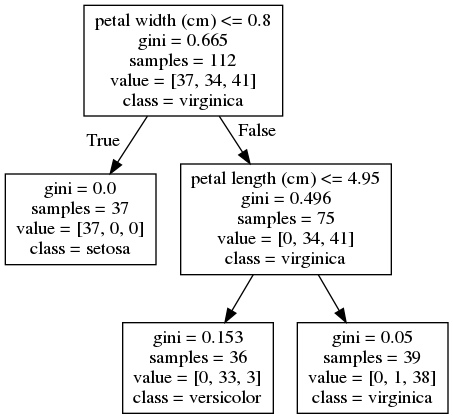

In [11]:
# Create DOT data
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [41]:
node_indicator

<38x5 sparse matrix of type '<class 'numpy.int64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [35]:
leave_id

array([4, 3, 1, 4, 1, 4, 1, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3,
       1, 1, 3, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 3, 1, 4])

In [48]:
## Collecting path - loop through this
node_indicator.indices[node_indicator.indptr[20]:node_indicator.indptr[21]]

array([0, 2, 3], dtype=int32)

In [46]:
## Converting path to strings
left_nodes = children_left[children_left>0]
right_nodes = children_right[children_right>0]

In [49]:
left_nodes

array([1, 3])

In [50]:
right_nodes

array([2, 4])

In [34]:
node_indicator.indices[node_indicator.indptr[31]:
                                    node_indicator.indptr[32]]

array([0, 2, 3], dtype=int32)

In [27]:
node_indicator.indptr

array([  0,   3,   6,   8,  11,  13,  16,  18,  21,  24,  27,  30,  33,
        36,  39,  42,  44,  47,  50,  52,  54,  57,  60,  62,  64,  67,
        69,  71,  74,  77,  79,  82,  85,  87,  90,  93,  96,  98, 101],
      dtype=int32)

In [36]:
feature

array([ 3, -2,  2, -2, -2])

In [37]:
threshold

array([ 0.80000001, -2.        ,  4.95000005, -2.        , -2.        ])

In [57]:
a = 's'

In [59]:
u = a.join('l')

In [60]:
u

'l'

In [76]:
test = np.array([])

np.append(test, 'start')

array(['start'], dtype='<U32')

In [77]:
np.append(test, 'end')

array(['end'], dtype='<U32')

In [91]:
test = load_iris()

In [92]:
test['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

---

## Sample RNN code from this [tutorial](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

In [16]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer()